# Simulations of trajectories and attractors on Boolean networks

This vignette displays some examples of what can be achieved using **NORDic** in order to observe generated state trajectories and attractors using common Boolean network dynamics, and validate an inferred network.

## Installation

In [1]:
import NORDic
! pip freeze | grep "NORDic"

NORDic @ file:///media/kali/1b80f30d-2803-4260-a792-9ae206084252/Code/M30/NetworkOrientedRepurposingofDrugs/dist/NORDic-2.3.5-py3-none-any.whl


In [2]:
import pandas as pd
import numpy as np
import os
from multiprocessing import cpu_count
from time import time

taxon_id = 9606
njobs=max(1,cpu_count()-2)
seednb=12345

## Network with the CCHS example

We import the network inferred with **NORDic NI** in previous notebooks.

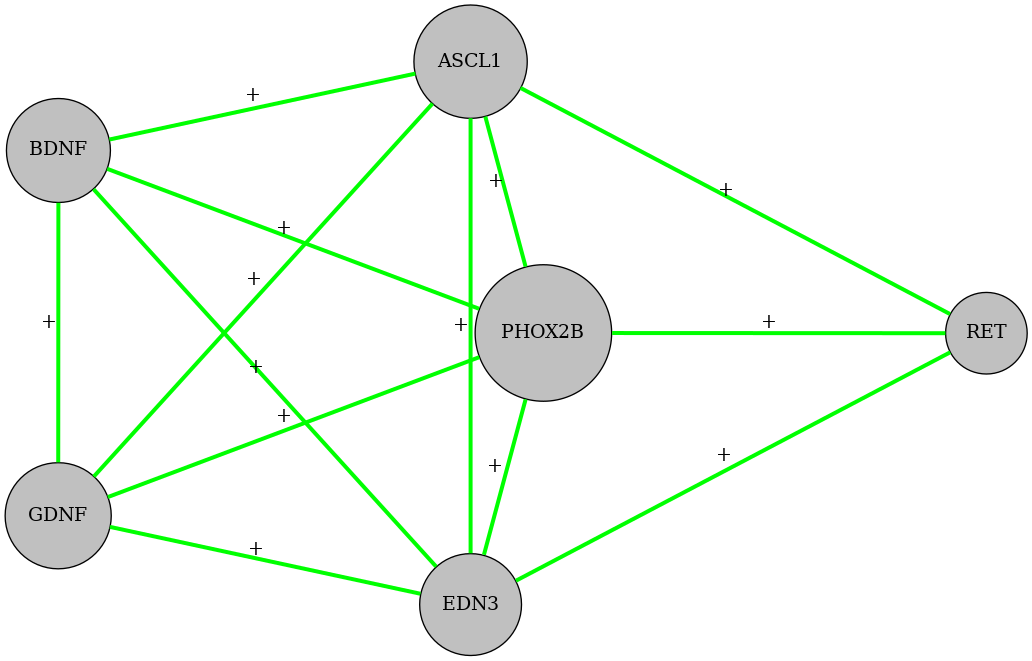

In [3]:
file_folder="ToyOndine/"
network_fname=file_folder+"solution.bnet"

from IPython.display import Image
Image(filename=file_folder+'inferred_maximal_solution.png') 

### A. Testing different dynamics, and generating trajectories

**NORDic.UTILS.utils_sim** implements three types of simulators:
- MABOSS_SIM, which wraps around package [MaBoSS](https://github.com/colomoto/pyMaBoSS) to generate trajectories and enumerate attractors under the asynchronous dynamics. The asynchronous dynamics are less rich than more recent ones (for instance, [Most Permissive dynamics](https://hal.science/hal-01864693/document)) but the implementation of MaBoSS using Markov Chains allows to reduce the computational cost for these operations. As such, using this simulator is rather efficient, and allows to get a first idea about the behavior of the network.
- MPBN_SIM, which wraps around package [mpbn](https://github.com/bnediction/mpbn) to generate trajectories and enumerate attractors under the Most Permissive dynamics. The main issue with this simulator is that it can be computationally expensive as the number of nodes grows, as the underlying functions rely on manually performing the update steps, which is combinatorial.
- BONESIS_SIM, which wraps around package [BoneSiS](https://github.com/bnediction/bonesis) and **do not** generate trajectories nor enumerate attractors, but can **test** whether an **attractor** is reachable from a given initial state under the Most Permissive dynamics. Using BONESIS_SIM is then less expensive than using MPBN_SIM.

In [4]:
import mpbn

net = mpbn.MPBooleanNetwork(mpbn.load(network_fname))
x0 = net.zero() # consider initial state where all gene expression levels are set to 0...
for g in ["ASCL1", "BDNF", "RET"]: #... except for ASCL1 and BDNF and RET
    x0[g] = 1

Using [mpbn](https://github.com/bnediction/mpbn), one can visualize the state-transition graph (i.e., states connected if one can go from one to the other by a single update step). Note that it can be **very** large and computationally expensive if the number of nodes is large

# computing graph layout...


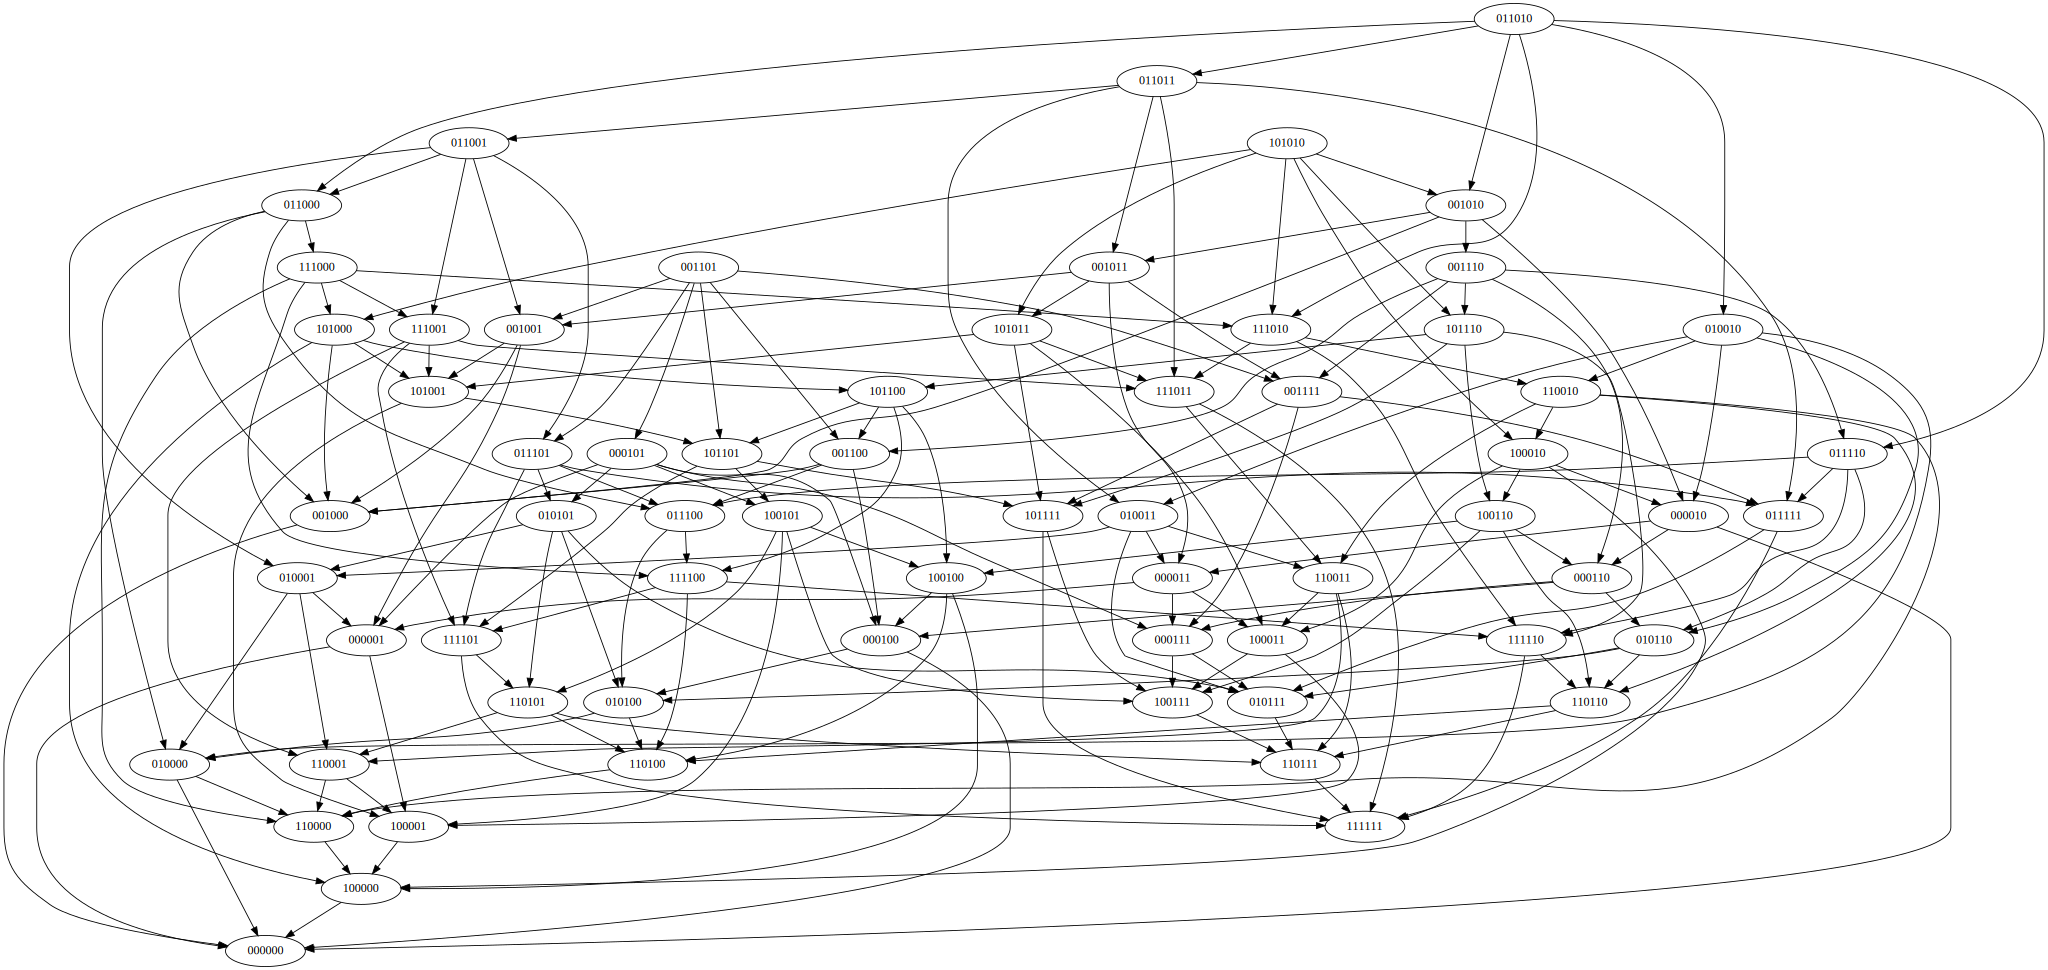

In [5]:
# dynamics in ["asynchronous", "fully-asynchronous", "general", "synchronous", "mp", "most-permissive"]
# "mp" stands for "most-permissive"
net.dynamics("asynchronous")

All of those simulators have the following functions:
- *update_network*, which updates the initial state of the network, the permanent mutations (i.e., knock-outs and knock_ins), and the transient mutations (one-time inhibitions/stimulations on genes). If the simulator is SIM, then the updated network can be accessed using SIM.network.
- *generate_trajectories*, which generates and plots trajectories of fixed length, and compute the frequencies of final states across all trajectories.
- *enumerate_attractors*, which enumerates (fixed point terminal) attractors reachable from the initial state.

#### A.1 Using asynchronous dynamics with MABOSS_SIM

# computing graph layout...


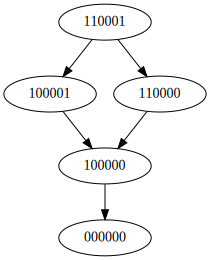

In [6]:
## Transitions from the considered initial state
net.dynamics("asynchronous", init=x0) 

Since we have considered asynchronous dynamics above, let us use [MaBoSS](https://github.com/colomoto/pyMaBoSS) to check whether generated trajectories satisfy the state-transition graph shown above. We generate 10,000 trajectories of length 20 (i.e., we iterate 20 times the update steps from the initial state). *outputs* allows to focus only on the genes present in the list *outputs*. By default, the simulator considers all genes in the network, at the exception of genes which have been mutated.

['ASCL1', 'BDNF', 'EDN3', 'GDNF', 'PHOX2B', 'RET']
Runtime (MABOSS_SIM) 0.08 sec


,{<nil>=1}
prob,1.0


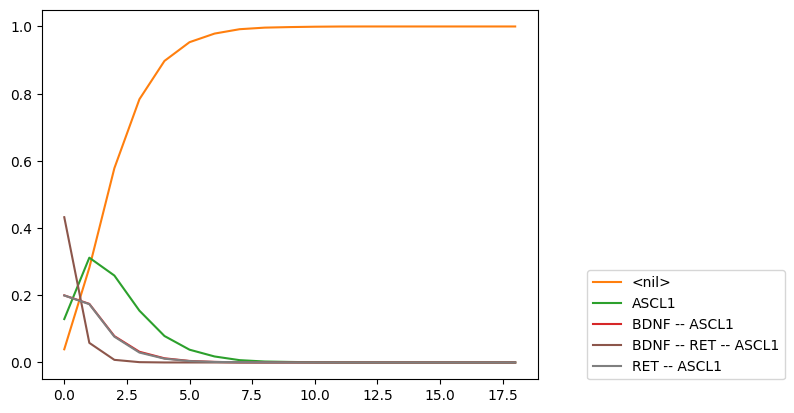

In [7]:
from NORDic.UTILS.utils_sim import MABOSS_SIM

initial = pd.DataFrame(pd.Series(x0), columns=["initial"])
params = {'sample_count': 10000, 'max_time': 20}
nee = MABOSS_SIM(seednb,njobs)
nee.update_network(network_fname, initial, verbose=False)
print(nee.gene_list)

start_time = time()
probs = nee.generate_trajectories(params=params, outputs=[]) ## generate trajectories
print("Runtime (MABOSS_SIM) %.2f sec" % (time()-start_time))
assert all([c=="{<nil>=1}" for c in probs.columns])
assert np.isclose(probs.loc["prob"]["{<nil>=1}"],1)
probs

As expected when looking at the state-transition graph, we end up in the final attractor 000000 '\<nil\>' (where the position of binary numbers correspond to the position of gene symbols in nee.gene_list), entering state 100000 from states 110000 and 100001 with equal probability (both red and grey curves are overlapping on the plot above), from initial state 110001 (brown curve with the steep decreasing slope).

#### A.2 Using most permissive dynamics with MPBN_SIM

# computing graph layout...


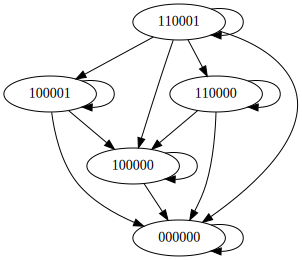

In [8]:
## Transitions from the considered initial state
net.dynamics("mp", init=x0) 

Now that we consider most permissive ("mp") dynamics, let us use [mpbn](https://github.com/bnediction/mpbn) to check whether generated trajectories satisfy the state-transition graph shown above. We generate 10,000 trajectories of length 20 (i.e., we iterate 20 times the update steps from the initial state).

['ASCL1', 'BDNF', 'EDN3', 'GDNF', 'PHOX2B', 'RET']


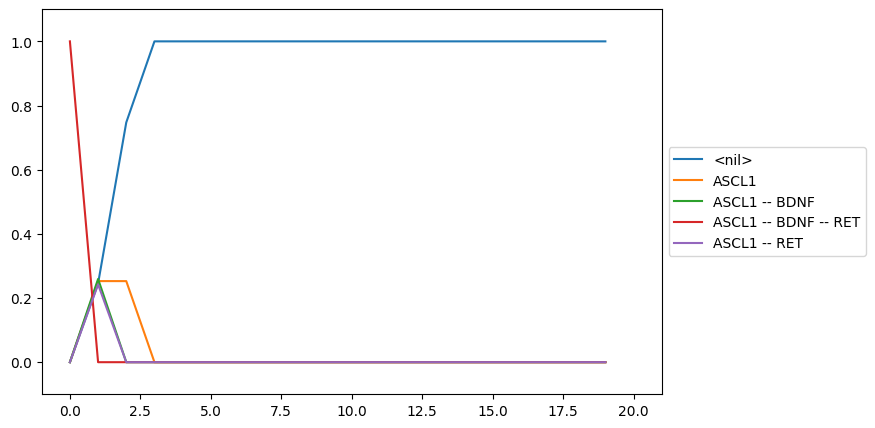

      <nil>
prob    1.0
Runtime (MPBN_SIM) 12.85 sec


,<nil>
prob,1.0


In [9]:
from NORDic.UTILS.utils_sim import MPBN_SIM

initial = pd.DataFrame(pd.Series(x0), columns=["initial"])
params = {'sample_count': 10000, 'max_time': 20}
nee = MPBN_SIM(seednb,njobs)
nee.update_network(network_fname, initial, verbose=False) ## no mutations, initial state x0
print(nee.gene_list)

start_time = time()
probs = nee.generate_trajectories(params=params, outputs=[]) ## generate trajectories
print(probs)
assert all([c=="{<nil>=1}" for c in probs.columns])
assert np.isclose(probs.loc["prob"]["{<nil>=1}"],1)
print("Runtime (MPBN_SIM) %.2f sec" % (time()-start_time))
probs

As expected when looking at the state-transition graph, we end up in the final attractor 000000 '\<nil\>' (where the position of binary numbers correspond to the position of gene symbols in nee.gene_list), entering state 100000 from states 110000 and 100001 with equal probability (overlapping green and purple curves), from initial state 110001 (red curve). Note that the trends in reaching each state are similar to the ones under asynchronous updates (see the previous subsection), but the simulator is significantly slower.

#### A.3 Using most permissive dynamics with BONESIS_SIM

# computing graph layout...


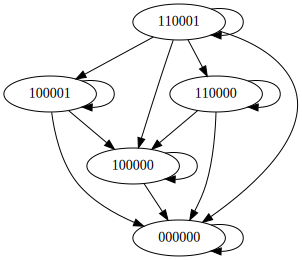

In [10]:
## Transitions from the considered initial state
net.dynamics("mp", init=x0) 

Let us confirm the results from the previous simulator using [BoneSiS](https://github.com/bnediction/bonesis), which might be useful when dealing with very large networks.

In [11]:
from NORDic.UTILS.utils_sim import BONESIS_SIM

initial = pd.DataFrame(pd.Series(x0), columns=["initial"])

## test if 000000 reachable from initial
final = pd.DataFrame([], index=[g for g in x0], columns=["final"]).fillna(0) 
nee = BONESIS_SIM(seednb,njobs)
nee.update_network(network_fname, initial, final, verbose=False) ## no mutations, initial state x0

start_time = time()
attrs = nee.enumerate_attractors(verbose=False) 
print("Runtime (BONESIS_SIM) %.2f sec" % (time()-start_time))

if ("StateNotFound" not in attrs.columns[0]):
    print("Attractor %s is reachable" % ("".join([str(x) for x in list(final["final"])])))
else:
    print("State %s is not reachable" % str_final)

Runtime (BONESIS_SIM) 0.03 sec
Attractor 000000 is reachable


In [12]:
## test if not reachable from initial
final = pd.DataFrame([[1,0,1,1,1,1]], columns=[g for g in x0], index=["final"]).T 
nee = BONESIS_SIM(seednb,njobs)
nee.update_network(network_fname, initial, final, verbose=False) ## no mutations, initial state x0

start_time = time()
attrs = nee.enumerate_attractors(verbose=False) 
print("Runtime (BONESIS_SIM) %.2f sec" % (time()-start_time))

str_final = "".join([str(x) for x in list(final["final"])])
if ("StateNotFound" not in attrs.columns[0]):
    print("Attractor %s is reachable" % str_final)
else:
    print("State %s is not reachable" % str_final)

Runtime (BONESIS_SIM) 0.02 sec
State 101111 is not reachable


### B. Enumerating attractor states

Considering the previous network, let us enumerate all reachable attractors using MaBoSS and mpbn, considering an initial which is located more upstream of the graph.

In [13]:
initial = pd.DataFrame([[1,0,1,0,1,0]], columns=[g for g in x0], index=["initial"]).T 
nee = MABOSS_SIM(seednb,njobs)
nee.update_network(network_fname, initial, verbose=False)
start_time = time()
nee.enumerate_attractors() ## enumerate all attractors
print("Runtime (enumerating with MABOSS_SIM) %.2f sec" % (time()-start_time))
nee.attrs

Runtime (enumerating with MABOSS_SIM) 0.22 sec


,S0,S1
ASCL1,1,0
BDNF,1,0
EDN3,1,0
GDNF,1,0
PHOX2B,1,0
RET,1,0


In [14]:
initial = pd.DataFrame([[1,0,1,0,1,0]], columns=[g for g in x0], index=["initial"]).T 
nee = MPBN_SIM(seednb,njobs)
nee.update_network(network_fname, initial, verbose=False)
start_time = time()
nee.enumerate_attractors() ## enumerate all attractors
print("Runtime (enumerating with MPBN_SIM) %.2f sec" % (time()-start_time))
nee.attrs

2it [00:00, 436.45it/s]

Runtime (enumerating with MPBN_SIM) 0.01 sec


,Attr0,Attr1
ASCL1,1,0
BDNF,1,0
EDN3,1,0
GDNF,1,0
PHOX2B,1,0
RET,1,0


Which is consistent with our previous observations (see the full state-transition graph above).

### C. Testing reachability

Now, let us test the reachability of a set of putative final attractor states T from a set of initial states C, potentially restricting to a subset of genes *gene_outputs* (default: all genes but mutated ones), with those three simulators. There are two approaches:
- "profiles" directly compares the set of final attractor states T to all attractors reachable from C.
- Acknowledging that the measured/observed states in T might not truly be attractor states (because it would require waiting for too long in order for the dynamical biological system to reach equilibrium), "attractors" compares attractor states reachable from T, and attractor states reachable from C.

In both cases, the returned score is 1 - Hamming distance normalized by the number of genes in *gene_outputs* (roughly, the number of equal coefficients in the binary vectors divided by the total number of coefficients, with a specific procedure when comparing NaN to binary values). The definition of the score is in function *compare_states*.

In [15]:
from NORDic.UTILS.utils_state import compare_states

help(compare_states)

Help on function compare_states in module NORDic.UTILS.utils_state:

compare_states(x, y, genes=None)
    Computes the similarity between two sets of Boolean states
    @param  x       Pandas DataFrame: rows/[genes] x columns/[state IDs] contains (0, 1, NaN)
    @param  y       Pandas DataFrame: rows/[genes] x columns/[state IDs] contains (0, 1, NaN)
    @param  genes   Python character string list: list of gene symbols 
    @returns        sims, N Similarities between each column of x and each columns of y, on the list of N present genes in @genes (if provided) 
    otherwise on the union of N genes in x and y



In [16]:
C = pd.DataFrame(pd.Series(x0), columns=["initial"])
T = pd.DataFrame([[1,0,1,1,1,1]], columns=[g for g in x0], index=["NotReachable"]).T 
T = T.join(pd.DataFrame([], index=[g for g in x0], columns=["Reachable"]).fillna(0), how="outer")
C

,initial
ASCL1,1
BDNF,1
EDN3,0
GDNF,0
PHOX2B,0
RET,1


In [17]:
T

,NotReachable,Reachable
ASCL1,1,0
BDNF,0,0
EDN3,1,0
GDNF,1,0
PHOX2B,1,0
RET,1,0


#### C.1. Testing reachability with MaBoSS (asynchronous dynamics)

In [18]:
from NORDic.UTILS.utils_sim import test

_, net_MABOSS_noMut = test(MABOSS_SIM,seednb,njobs,network_fname,C,T,"profiles",verbose=0)
res = pd.DataFrame({"score": net_MABOSS_noMut.max_values}).T
res

,initial->NotReachable,initial->Reachable
score,0.166667,1.0


One can interpret this table as:
- State "NotReachable" is not reachable from C (as expected by previous results) as the score is strictly smaller than 1, and the similarity between this state and the most similar attractor reachable from C is around 0.17
- State "Reachable" is reachable from C (as expected by previous results) as the score is equal to 1

In [19]:
_, net_MABOSS_noMut = test(MABOSS_SIM,seednb,njobs,network_fname,C,T,"attractors",verbose=0)
pd.DataFrame({"score": net_MABOSS_noMut.max_values}).T

,initial->NotReachable,initial->Reachable
score,0.0,1.0


One can interpret this table as:
- There is no attractor reachable from State "NotReachable" which is also an attractor reachable from C (as expected by previous results) as the score is equal to 0. If the score were smaller than 1 but greater than 0, then it would have meant that there is no attractor both reachable from C and "NotReachable", and the maximum similarity between an attractor reachable from T and the most similar attractor reachable from C is equal to the score. Indeed, the attractor reachable from T is actually 111111, which has a similarity score equal to 0 with the attractor reachable from C, which is 000000.
- There is an attractor reachable from State "Reachable" which is also an attractor reachable from C (as expected by previous results) as the score is equal to 1. Actually, we know that this attractor is equal to the state "Reachable" according to our previous results.

#### C.2. Testing reachability with mpbn (most permissive dynamics)

In [20]:
_, net_MPBN_noMut = test(MPBN_SIM,seednb,njobs,network_fname,C,T,"profiles",verbose=0)
pd.DataFrame({"score": net_MPBN_noMut.max_values}).T

1it [00:00, 234.44it/s]
1it [00:00, 331.20it/s]


,initial->NotReachable,initial->Reachable
score,0.166667,1.0


In [21]:
_, net_MPBN_noMut = test(MPBN_SIM,seednb,njobs,network_fname,C,T,"attractors",verbose=0)
pd.DataFrame({"score": net_MPBN_noMut.max_values}).T

1it [00:00, 307.84it/s]
1it [00:00, 354.70it/s]
1it [00:00, 344.47it/s]
0it [00:00, ?it/s]domRec ignored: No domain atoms found.
1it [00:00, 248.96it/s]


,initial->NotReachable,initial->Reachable
score,0.0,1.0


These results confirm what we saw with asynchronous dynamics.

#### C.3. Testing reachability with BoneSiS (most permissive dynamics)

In [22]:
_, net_BONESIS_noMut = test(BONESIS_SIM,seednb,njobs,network_fname,C,T,"profiles",verbose=0)
pd.DataFrame({"score": net_BONESIS_noMut.max_values}).T

,initial->NotReachable,initial->Reachable
score,0.0,1.0


The difference of the BoneSiS-based simulator with the other two is that, since it does not enumerate attractors, then the score can only take values 0 (no reachability) or 1 (reachability). As such, using value "profiles" or "attractors" will give the same result.

In [23]:
_, net_BONESIS_noMut = test(BONESIS_SIM,seednb,njobs,network_fname,C,T,"attractors",verbose=0)
pd.DataFrame({"score": net_BONESIS_noMut.max_values}).T

,initial->NotReachable,initial->Reachable
score,0.0,1.0


### D. Dealing with mutants (knock-outs, knock-ins, or transient stimulations/inhibitions)

Function *update_network* in all three simulators can take as input a dictionary which describes mutations (or transient initial stimulations) to be applied to the network. All functions previously described still apply to those networks.

In [24]:
from NORDic.UTILS.utils_sim import MABOSS_SIM

help(MABOSS_SIM(seednb, njobs).update_network)

Help on method update_network in module NORDic.UTILS.utils_sim:

update_network(network_fname, initial, final=None, mutation_permanent={}, mutation_transient={}, verbose=True) method of NORDic.UTILS.utils_sim.MABOSS_SIM instance



#### D.1 Permanent mutations (knock-outs, knock-ins)

If PHOX2B is knocked-out

In [25]:
nee = MPBN_SIM(seednb,njobs)
nee.update_network(network_fname, initial, mutation_permanent={'PHOX2B': 0}, verbose=False)
nee.all_mutants

['PHOX2B']

If PHOX2B is knocked-in

In [26]:
nee = MPBN_SIM(seednb,njobs)
nee.update_network(network_fname, initial, mutation_permanent={'PHOX2B': 1}, verbose=False)
nee.all_mutants

['PHOX2B']

#### D.2 Transient 'mutations' (initial stimulations/inhibitions)

If PHOX2B is transiently initially stimulated

In [27]:
nee = BONESIS_SIM(seednb,njobs)
nee.update_network(network_fname, initial, mutation_transient={'PHOX2B': 1}, verbose=False)
nee.all_mutants

['PHOX2B']

If PHOX2B is transiently initially inhibited

In [28]:
nee = BONESIS_SIM(seednb,njobs)
nee.update_network(network_fname, initial, mutation_transient={'PHOX2B': 0}, verbose=False)
nee.all_mutants

['PHOX2B']

#### D.3 Testing reachability with mutants

In [29]:
_, net_MPBN_noMut = test(MPBN_SIM,seednb,njobs,network_fname,C,T,
                                      "profiles", mutation_permanent={'PHOX2B': 0},verbose=0)
pd.DataFrame({"score": net_MPBN_noMut.max_values}).T

1it [00:00, 362.55it/s]
1it [00:00, 386.93it/s]


,initial->NotReachable,initial->Reachable
score,0.2,1.0


In [30]:
_, net_MPBN_noMut = test(MPBN_SIM,seednb,njobs,network_fname,C,T,
                                      "profiles", mutation_transient={'EDN3': 0},verbose=0)
pd.DataFrame({"score": net_MPBN_noMut.max_values}).T

1it [00:00, 376.07it/s]
1it [00:00, 377.63it/s]


,initial->NotReachable,initial->Reachable
score,0.2,1.0
